In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Input
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'JPM_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [ ]:
diff_close_series = df['Close'].diff().dropna()

In [ ]:
lag_df = pd.DataFrame({
    't-1': diff_close_series.shift(1),
    't': diff_close_series,
    't+1': diff_close_series.shift(-1)
}).dropna()

In [ ]:
lag_df['diff t-1'] = lag_df['t'] - lag_df['t-1']
lag_df['diff t'] = lag_df['t+1'] - lag_df['t']

In [ ]:
split_idx = len(lag_df) // 2
train_data = lag_df.iloc[:split_idx]
test_data = lag_df.iloc[split_idx:]

In [ ]:
X_train = train_data[['diff t-1', 't']].values
y_train = train_data['t+1'].values

In [ ]:
X_test = test_data[['diff t-1', 't']].values
y_test = test_data['t+1'].values

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [ ]:
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))


In [ ]:
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [ ]:
input_layer = Input(shape=(1, 2)) 

In [ ]:
model = Sequential([
    Input(shape=(1, 2)),  # Define input shape separately
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_train_reshaped, y_train_scaled, epochs=700, batch_size=8, verbose=0)

In [ ]:
X_input = X_test_scaled.copy()
y_pred_scaled = []

In [ ]:
for i in range(len(X_test_scaled)):
    X_reshaped = X_input[i].reshape(1, 1, 2)  # Reshape for LSTM
    pred_scaled = model.predict(X_reshaped)[0, 0]  # Predict t+1
    y_pred_scaled.append(pred_scaled)

    # Update input for the next iteration
    if i < len(X_test_scaled) - 1:
        X_input[i + 1, 0] = X_input[i, 1]  # Move t → t-1
        X_input[i + 1, 1] = pred_scaled 

In [ ]:
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R²: {r2:.6f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences')
plt.plot(y_pred, label='Predicted Differences', linestyle='dashed')
plt.title("Close Price Differences: Actual vs Predicted (Iterative LSTM)")
plt.legend()
plt.show()

In [ ]:
# lagdata = pd.concat(
#     [diff_close_series.shift(i) for i in range(5, -1, -1)],
#     axis=1
# ).dropna()
# lagdata.columns = [f'lag_{i}' for i in range(5, -1, -1)]
# X = lagdata.iloc[:, 1:].values  
# y = lagdata.iloc[:, 0].values

In [ ]:
#diffcloseseires = df['Close'].diff().dropna()

In [ ]:
scalerx = StandardScaler()
xscaled = scalerx.fit_transform(X)

In [ ]:
X_reshaped = xscaled.reshape((xscaled.shape[0], xscaled.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_reshaped, y, epochs=200, batch_size=8, verbose=0)

In [ ]:
ypredlist = []

In [ ]:
for i in range(len(xscaled)):
    X_input = xscaled[i].reshape((1, X_reshaped.shape[1], 1))
    
    y_pred_raw = model.predict(X_input, verbose=0)
    ypredlist.append(y_pred_raw[0][0]) 

In [ ]:
y_pred = np.array(ypredlist)

scaler_y = StandardScaler()
y_scaled_actual = scaler_y.fit_transform(y.reshape(-1, 1))
y_scaled_pred = scaler_y.transform(y_pred.reshape(-1, 1))

In [ ]:
mse = mean_squared_error(y_scaled_actual, y_scaled_pred)
r2 = r2_score(y_scaled_actual, y_scaled_pred)

In [ ]:
print(f"LSTM MSE: {mse:.6f}")
print(f"LSTM R2: {r2:.6f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_scaled_actual, label='actual differences')
plt.plot(y_scaled_pred, label='predicted differences', linestyle='dashed')
plt.title("close price differences: actual vs predicted (LSTM)")
plt.legend()
plt.show()

aarima and sarima

In [ ]:
arima_order = (3, 1, 2)  # You can tune these parameters
arima_model = ARIMA(y, order=arima_order)
arima_fitted = arima_model.fit()

In [ ]:
y_pred_arima = arima_fitted.predict(start=0, end=len(y) - 1)

In [ ]:
sarima_order = (5, 1, 2)   # Non-seasonal parameters
seasonal_order = (1, 1, 1, 12)  # Seasonal parameters (tune `m`)
sarima_model = SARIMAX(y, order=sarima_order, seasonal_order=seasonal_order)
sarima_fitted = sarima_model.fit()

In [ ]:
y_pred_sarima = sarima_fitted.predict(start=0, end=len(y) - 1)

In [ ]:
mse_arima = mean_squared_error(y, y_pred_arima)
r2_arima = r2_score(y, y_pred_arima)

In [ ]:
mse_sarima = mean_squared_error(y, y_pred_sarima)
r2_sarima = r2_score(y, y_pred_sarima)

In [ ]:
print(f"ARIMA MSE: {mse_arima:.6f}, R²: {r2_arima:.6f}")
print(f"SARIMA MSE: {mse_sarima:.6f}, R²: {r2_sarima:.6f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Differences', color='blue')
plt.plot(y_pred_arima, label='ARIMA Predictions', linestyle='dashed', color='red')
plt.plot(y_pred_sarima, label='SARIMA Predictions', linestyle='dashed', color='green')
plt.title("Close Price Differences: ARIMA & SARIMA Predictions")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

# Compute differences
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.8)  # 80 - 20
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]

# Separate features (X) and target (y) for train and test
X_train = train_data.iloc[:, 1:].values  # lag_1 to lag_5
y_train = train_data.iloc[:, 0].values   # lag_0
X_test = test_data.iloc[:, 1:].values    # lag_1 to lag_5
y_test = test_data.iloc[:, 0].values     # lag_0

# Scale the data (fit on train only to avoid leakage)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Use transform, not fit_transform
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))  # Use transform, not fit_transform

# Reshape for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, activation='leaky relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Train the model on the training set
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)

# Predict on both train and test sets
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.6f}")
print(f"Train R2: {r2_train:.6f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test R2: {r2_test:.6f}")

# Plot actual vs predicted differences for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set)")
plt.legend()
plt.show()

Epoch 1/200


/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


373/373 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9282
Epoch 2/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0812
Epoch 3/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0265
Epoch 4/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8716
Epoch 5/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9893
Epoch 6/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1744
Epoch 7/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9126
Epoch 8/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0097
Epoch 9/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9252
Epoch 10/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0142
Epoch 11/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8901
Epoch 12/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9108
Epoch 13/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1764
Epoch 14/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9804
Epoch 15/200
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

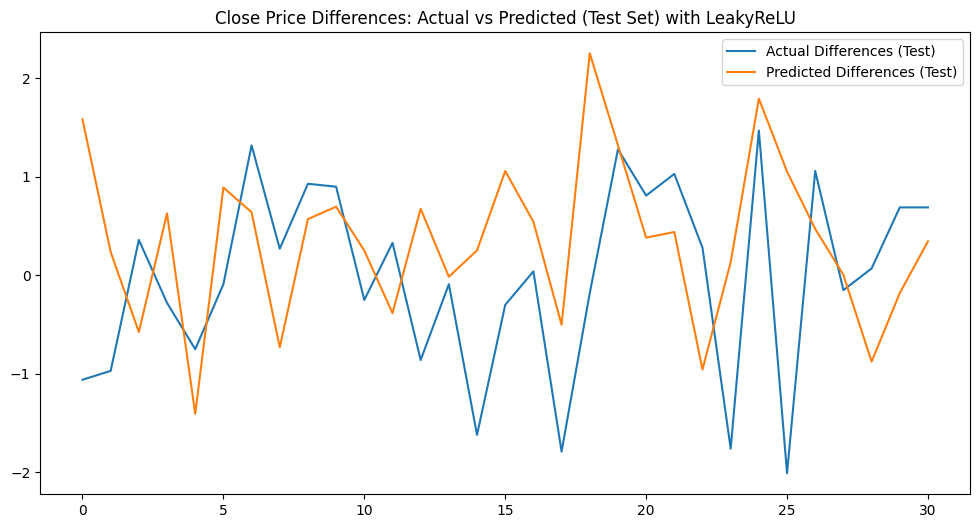

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU  # Import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Load the dataset
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

# Compute differences
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.5)  # 50% split
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]

# Separate features (X) and target (y) for train and test
X_train = train_data.iloc[:, 1:].values  # lag_1 to lag_5
y_train = train_data.iloc[:, 0].values   # lag_0
X_test = test_data.iloc[:, 1:].values    # lag_1 to lag_5
y_test = test_data.iloc[:, 0].values     # lag_0

# Scale the data (fit on train only to avoid leakage)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define and compile the LSTM model with LeakyReLU
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=False))  # No activation here
model.add(LeakyReLU(alpha=0.01))  # Add LeakyReLU with default alpha=0.01
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model on the training set
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)

# Predict on both train and test sets
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.6f}")
print(f"Train R2: {r2_train:.6f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test R2: {r2_test:.6f}")

# Plot actual vs predicted differences for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set) with LeakyReLU")
plt.legend()
plt.show()

Epoch 1/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3115
Epoch 2/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0744
Epoch 3/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8932
Epoch 4/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9742
Epoch 5/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8140
Epoch 6/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7565
Epoch 7/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0605
Epoch 8/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3516
Epoch 9/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8264
Epoch 10/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8210
Epoch 11/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7806
Epoch 12/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7929
Epoch 13/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8718
Epoch 14/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1906
Epoch 15/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0

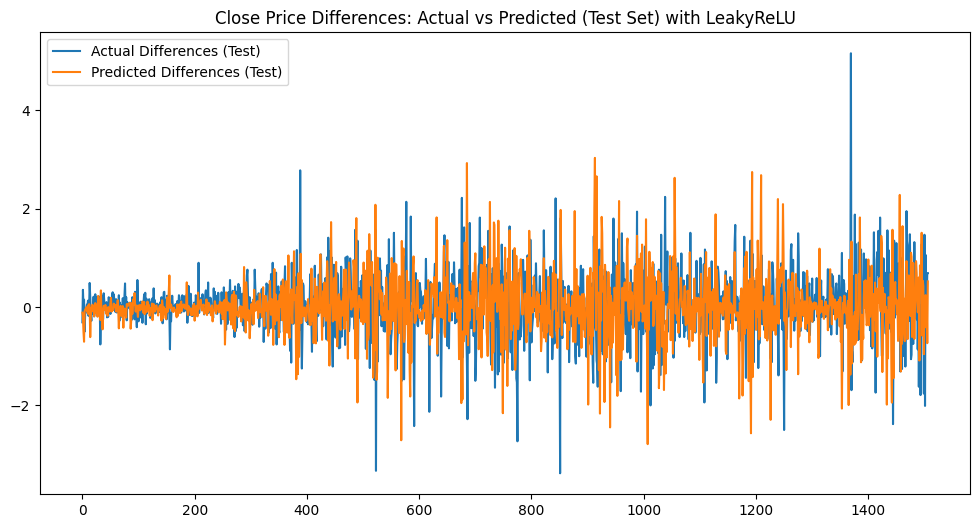

In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Input  # Add Input
from tensorflow.keras.optimizers import Adam

# Load the dataset
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

# Compute differences
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.5)
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]

# Separate features (X) and target (y) for train and test
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define and compile the LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=False))
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)

# Predict on both train and test sets
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.6f}")
print(f"Train R2: {r2_train:.6f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test R2: {r2_test:.6f}")

# Plot actual vs predicted differences for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set) with LeakyReLU")
plt.legend()
plt.show()